In [1]:
# Run this cell before continuing.
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Examining Correlations between location and crime Rates

## Introduction
---

Our dataset contains crime data for 2022 in Vancouver. For each entry, we have recorded the type of crime, and we are specifically focusing on three crime types: "Break and Enter Residential/Other," "Break and Enter Commercial," and "Mischief." We also have information about the date and time the crime occurred, the address, neighborhood, and geographic coordinates.

The question we are trying to answer is whether there is a correlation between the geographic location of these specific types of crime and the frequency of criminal incidents. Our analysis seeks to determine if crime predominantly occurs in either the east or west side of Vancouver, as defined by the "X" coordinate. Crimes with "X" values less than 491984.0931 are categorized as the "west" side, while values greater than or equal to this threshold are considered the "east" side.

In this study, we use the "X" coordinate as a key variable to understand the spatial distribution of these specific crime types. This approach allows us to focus on the geographical aspect of crime patterns for "Break and Enter Residential/Other," "Break and Enter Commercial," and "Mischief" incidents. 

Our null hypothesis is that these three specific types of crime are evenly distributed between the east and west sides of Vancouver. Our alternative hypothesis is that crime will occur more in the west side of Vancouver, X < 491984.0931, in coordinate. Downtown Vancouver has frequently been associated with higher rates of criminality, according to many news and these are one of the most hazardous locations in Vancouver.

### Parameters of Interest:

* Location Parameter (Mean): 

Our primary location parameter is the mean. We want to calculate the mean number of incidents for each of the three crime types on both the west and east sides of Vancouver. This parameter will help us identify if there is a significant difference in the average occurrence of these crimes in the two geographical areas.

* Scale Parameter (Standard Deviation):

The standard deviation will be a secondary parameter of interest. We'll calculate the standard deviation for each crime type in both west and east sides of Vancouver. This parameter is important because it allows us to assess the variability or dispersion of crime occurrences within each group. It can help us understand how consistent or variable crime patterns are in each area.

## Preliminary Results
---

In [2]:
# setwd("/home/jovyan/work/project")

In [3]:
crime_data <- read_csv("data/crimedata_csv_AllNeighbourhoods_2022.csv")
head(crime_data)

Rows: 34281 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2022,1,3,16,19,10XX ALBERNI ST,West End,491036.1,5459146
Break and Enter Commercial,2022,6,17,5,16,10XX ALBERNI ST,West End,491067.3,5459115
Break and Enter Commercial,2022,3,15,5,14,10XX ALBERNI ST,West End,491102.2,5459092
Break and Enter Commercial,2022,3,19,6,42,10XX ALBERNI ST,West End,491102.2,5459092
Break and Enter Commercial,2022,2,23,23,0,10XX BALFOUR AVE,Shaughnessy,490699.8,5455444
Break and Enter Commercial,2022,2,25,10,15,10XX BALFOUR AVE,Shaughnessy,490699.8,5455444


In [59]:
crime_X <- crime_data[c("X","TYPE")]

#### Explanation of the population month histogram
The frequency of crimes seems to be quite consistent throughout the year ranging from 2400 - 3200 crimes per month. There is a noticeable increase in crimes from July till October and drop in crimes in November and December.  

#### Explanation of each category mode
The table and the plots show the most frequent number of crimes per month in each category 

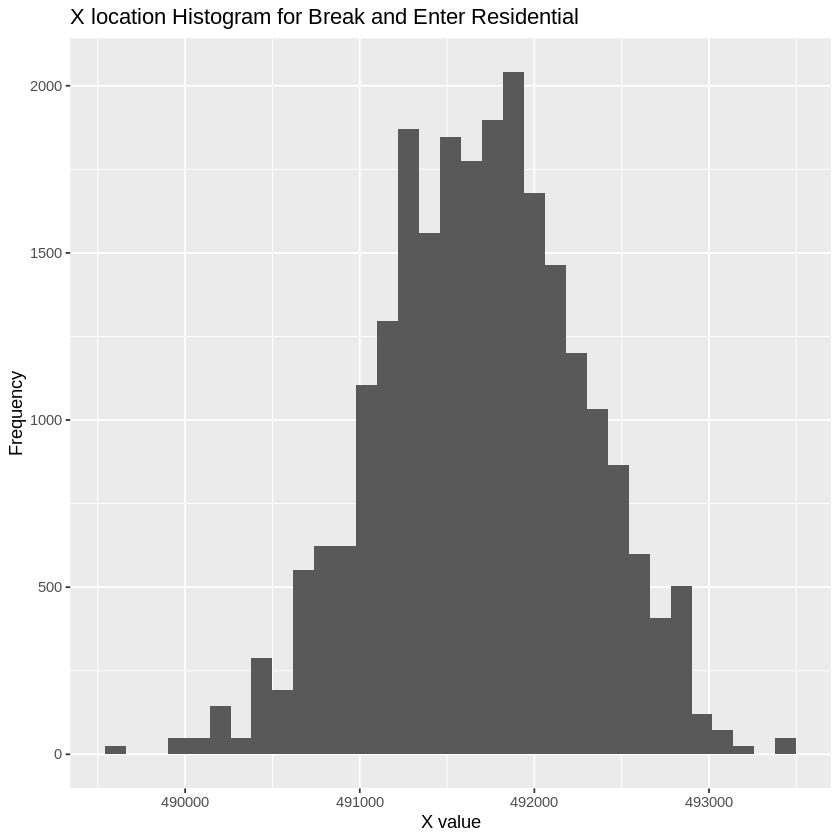

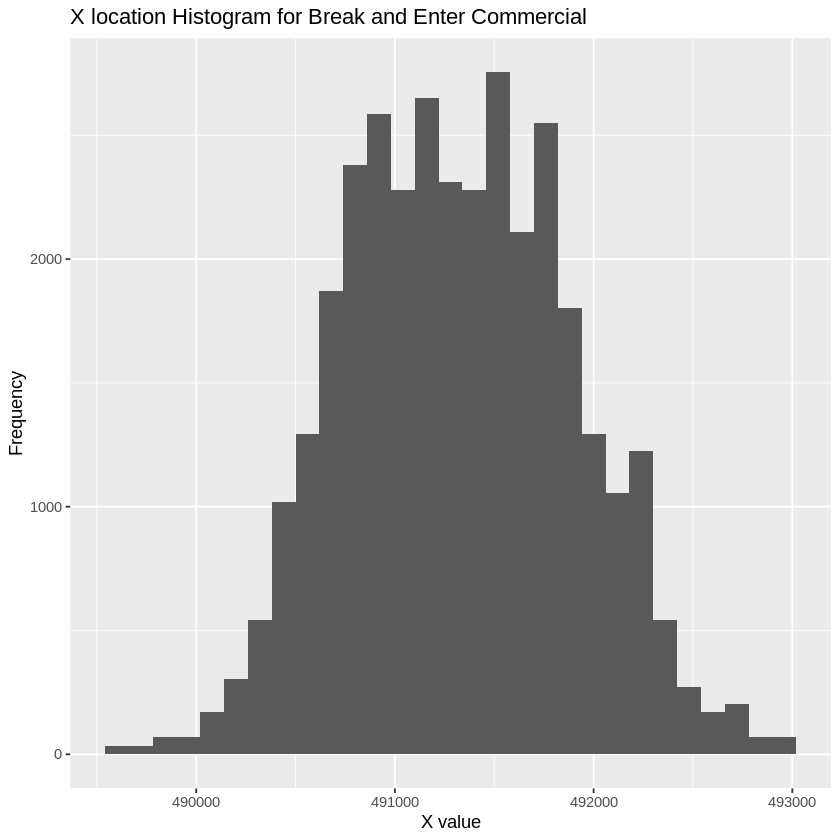

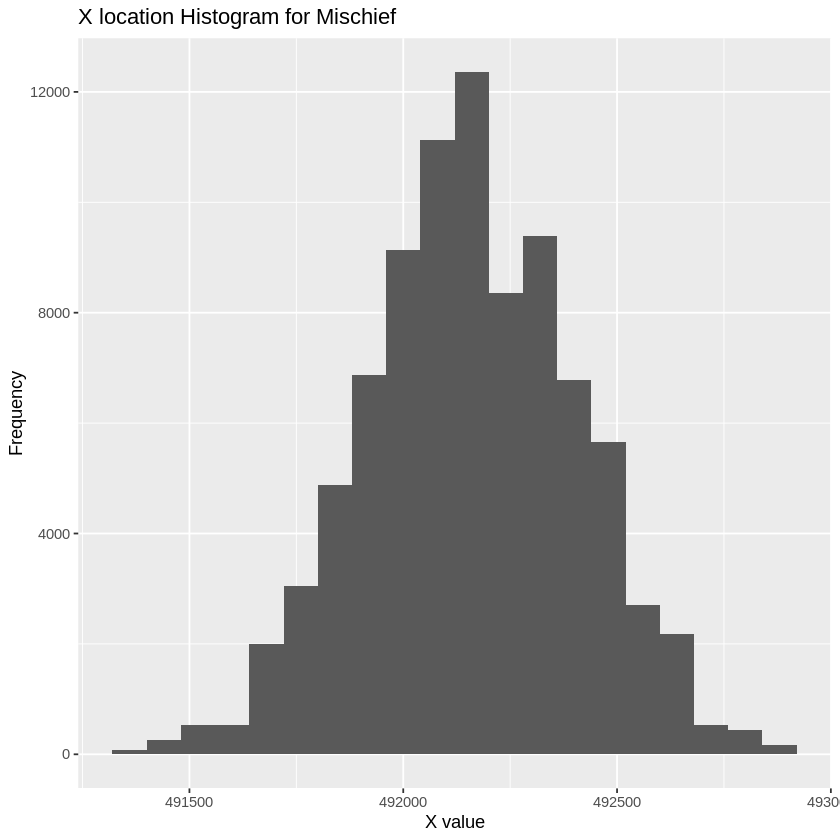

In [114]:
# cleaning the data
crime_X <- crime_X[complete.cases(crime_X), ]
crime_X <- subset(crime_X, X != 0)
# one sample
crime_X <- crime_X %>%
    rep_sample_n(reps = 1, size = 500, replace = FALSE) %>% ungroup() %>% select(X,TYPE)

crime_X_res <- crime_X[crime_X$TYPE == "Break and Enter Residential/Other", ]
crime_X_com <- crime_X[crime_X$TYPE == "Break and Enter Commercial", ]
crime_X_mis <- crime_X[crime_X$TYPE == "Mischief", ]

# making bootstrap samples

crime_X_res_samples <- crime_X_res %>%
    rep_sample_n(reps = 1000, size = nrow(crime_X_res), replace = TRUE) %>% 
    group_by(replicate) %>%
    reframe(mean = mean(X),category = TYPE)
ggplot(crime_X_res_samples, aes(x = mean)) +
  geom_histogram(binwidth = 120) +
  labs(title = "X location Histogram for Break and Enter Residential", x = "X value", y = "Frequency")


crime_X_com_samples <- crime_X_com %>%
    rep_sample_n(reps = 1000, size = nrow(crime_X_com), replace = TRUE) %>% 
    group_by(replicate) %>%
    reframe(mean = mean(X),category = TYPE)
ggplot(crime_X_com_samples, aes(x = mean)) +
  geom_histogram(binwidth = 120) +
  labs(title = "X location Histogram for Break and Enter Commercial", x = "X value", y = "Frequency")


crime_X_mis_samples <- crime_X_mis %>%
    rep_sample_n(reps = 1000, size = nrow(crime_X_mis), replace = TRUE) %>% 
    group_by(replicate) %>%
    reframe(mean = mean(X),category = TYPE)
ggplot(crime_X_mis_samples, aes(x = mean)) +
  geom_histogram(binwidth = 80) +
  labs(title = "X location Histogram for Mischief", x = "X value", y = "Frequency")


In [115]:
mean(crime_X_com_samples$mean) > 491984.0931

[1] FALSE

In [116]:
sd(crime_X_com_samples$mean)

[1] 566.1016

In [117]:
mean(crime_X_res_samples$mean) > 491984.0931

[1] FALSE

In [118]:
sd(crime_X_com_samples$mean)

[1] 566.1016

In [119]:
mean(crime_X_mis_samples$mean) > 491984.0931

[1] TRUE

In [120]:
sd(crime_X_com_samples$mean)

[1] 566.1016

Report: As we can see Break and Enter happens mostly at west so we reject null hypothesis and for mischief, it mostly happens at east so we accept null hypothesis.

## Methods: Plan

---
For our hypothesis testing the null hypothesis is that there is equal crime rates between the west and east sides of Vancouver. The alternative is that the west side has more crime than the east. For this our confidence level will be 95%. In this case it would be better to use bootstrapping rather than the asymptotic method as the asymptotic method relies on the data to already follow a  normal distribution. If the p-value is less than 0.05 after conducting bootstrapping we will reject the null hypothesis.

* What do you expect to find?

We expect to find our alternative hypothesis to be true. Crime will be the most common in the west area (downtown), X < 491984.0931 in coordinate, and this trend will stay consistent for different types of crimes and for different neighbourhoods within Vancouver. 
 
* What impact could such findings have?

Understanding the relationship between location and crime can tell law enforcement agencies when and where to allocate police resources efficiently. It may additionally cause more centred and efficient policing techniques, reducing crime rates during peak periods.

* What future questions could this lead to?

Beyond location, what different elements (i.e. weather, events, or tourism) could influence crime rates? Our research can be continued with those variables to inspect why the west side (downtown) has a significantly higher rate than other areas.

How do economic factors, such as income levels, education, and employment opportunities, differ between the west and east sides of Vancouver, and to what extent do these disparities correlate with crime rates.
References
Staysafevancouver. (2023, August 31). Vancouver crime rate: Areas to avoid. Stay Safe Vancouver. https://www.staysafevancouver.com/post/vancouver-crime-rate 

West side rated safer than East Side neighbourhoods: Vancouver police survey. The Georgia Straight. (2019, February 21). https://www.straight.com/news/1203621/west-side-rated-safer-east-side-neighbourhoods-vancouver-police-survey 
